# Activity 3.3 Logistic Regression
In this activity we implement logistic regression using Stochastic Gradient Dessent (SGD) to solve a binary classification problem. 

## Steps to Build a Logistic Regression
Taking the following steps is neccesseary to build a logistic regression:
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In the followings, we implement each of these steps.

## Dataset
Similar to Activities 3.1 and 3.2, we generate a synthetic dataset and learn the model based on that.

In [1]:
# Data Generation
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)
## Initialization
set.seed(123)
N <- 1000
c0 <- '+1'; c1 <- '-1' # class labels
mu0 <- c(4.5, 0.5); p0 <- 0.60
mu1 <- c(1.0, 4.0); p1 <- 1 - p0
sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 <- sigma;   sigma1 <- sigma
data <- data.frame(x1=double(), x2=double(), label=factor(levels = c(c0,c1))) # empty data.frame
## Generate class labels
data[1:N,'label'] <- sample(c(c0,c1), N, replace = TRUE, prob = c(p0, p1))
## calculate the size of each class
N0 <- sum(data[1:N,'label']==c0); N1 <- N - N0
## Sample from the Gaussian distribution accroding to the class labels and statitics.
data[data[1:N,'label']==c0, c('x1', 'x2')] <- rmvnorm(n = N0, mu0, sigma0)
data[data[1:N,'label']==c1, c('x1', 'x2')] <- rmvnorm(n = N1, mu1, sigma1)
## Split data to train and test datasets
train.len <- round(N/2)
test.len  <- N - train.len
train.index <- sample(1:N, train.len, replace = FALSE)
train.data <- data[train.index, c('x1', 'x2')]; train.label <- data[train.index, 'label']
test.data <- data[-train.index, c('x1', 'x2')]; test.label <- data[-train.index, 'label']

### Visualization of The Generated Data

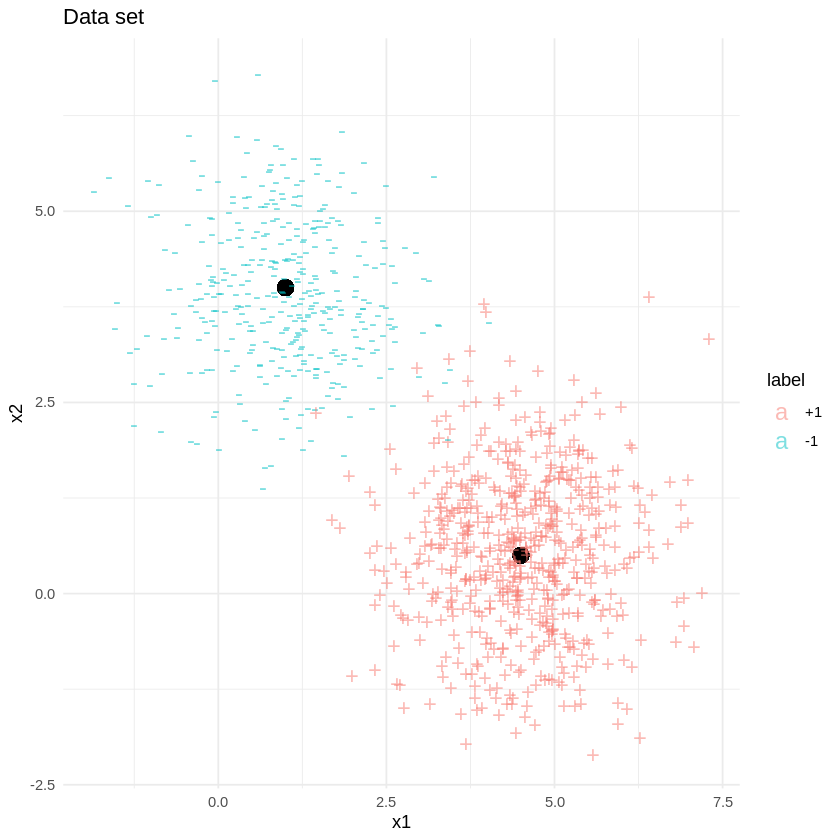

In [2]:
## Take a look at the data set
ggplot(data=data, aes(x=x1, y=x2, color=label, label=ifelse(label==c0, '+', '-'))) +
    geom_point(x=mu0[1], y=mu0[2], size=4, color = 'black') +
    geom_point(x=mu1[1], y=mu1[2], size=4, color = 'black') +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') + 
    theme_minimal()

## Building Logistic Regression
Similar to the previous activities, we first define some auxilary functions and then develop the logsitic regresion.
### Auxilary Functions

In [3]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig<=0.5, c0, c1))
}
    
# auxiliary function that calculates a cost function
## sig : p(C1) for an input x
## 1- sig :  p(C0) for an input x
## cost : some of the probabilities.
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# auxiliary function that returns TRUE when termination criteria are met
terminate <- function(tau, tau.max, W, X, T, c0, epsilon){
    return(ifelse(tau==1, FALSE,   # not terminate in the first iteration
                  tau >= tau.max | # terminate after tau.max iterations
                  abs(cost(W[tau,],X,T, c0) - cost(W[tau-1,],X,T, c0)) <=epsilon)) # terminate if cost hasn't been changed much
}


**Step 1 (Sigmoid):** Let's define our sigmoid function, first.

In [4]:
# Sigmoid function (=p(C1|X))
## cbind(1,x) : adds a column of 1 to dataset (to be multiplied by w0)
## w%*%t(cbind(1,x)) : the predicted scores (yet to be mapped to [0,1])
## 1.0/(1.0+exp(-w%*%t(cbind(1,x)))) : a real number in the range [0,1] which indicates p(C1) for each input x
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

**Step 1 (initializations):** Now, we initiate the weight vector, learning rate, stopping threshold, etc.

In [5]:
# Initializations
tau.max   <- 1000  # maximum number of iterations
eta       <- 0.10  # learning rate
epsilon   <- 0.01  # a threshold on the cost (to terminate the process)
tau       <- 1     # iteration counter

train.error = matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
test.error  = matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors

## Just a few name/type conversion to make the rest of the code easier to follow
X <- as.matrix(train.data)       # rename just for conviniance
T <- ifelse(train.label==c0,0,1) # rename just for conviniance

W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

# project data using the sigmoid function (just for convenient)
Y <- sigmoid(W[1,],X)

costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
costs[1, 'cost'] <- cost(W[1,],X,T, c0)


errors <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
errors[1, 'train'] <- sum(predict(W[tau,],train.data,c0,c1)!=train.label)/train.len*100
errors[1, 'test']  <- sum(predict(W[tau,],test.data,c0,c1)!=test.label)/test.len*100

**Step 2:** Here, we use SGD to learn the weight vector. Note that there are two loops. In the outter loop, we shuffle the samples and then start the inner loop. In the inner loop, we visit the training samples one by one and update the weights accordingly.

In [6]:
while(!terminate(tau, tau.max, W, X, T, c0, epsilon)){
        
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    X <- X[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        
        Y <- sigmoid(W[tau,],X)
            
        # Update the weights
        W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
        
        # record the cost and errors:
        costs[(tau+1), 'cost']   <- cost(W[tau,],X,T, c0)
        errors[(tau+1), 'train'] <- sum(predict(W[tau,],train.data,c0,c1)!=train.label)/train.len*100
        errors[(tau+1), 'test']  <- sum(predict(W[tau,],test.data,c0,c1)!=test.label)/test.len*100
        
        # update the counter:
        tau <- tau + 1
        
        # decrease learning rate:
        eta = eta * 0.99
        
        # check termination criteria:
        if (terminate(tau, tau.max, W, X, T, c0, epsilon)){break}
    }
}
# Done!
costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)
errors <- errors[1:tau,]

# the  final result is:
w <- W[tau,]
cat('\nThe  final coefficents are:',w)


The  final coefficents are: -0.03923123 -1.15214 1.046851

# Visualizations

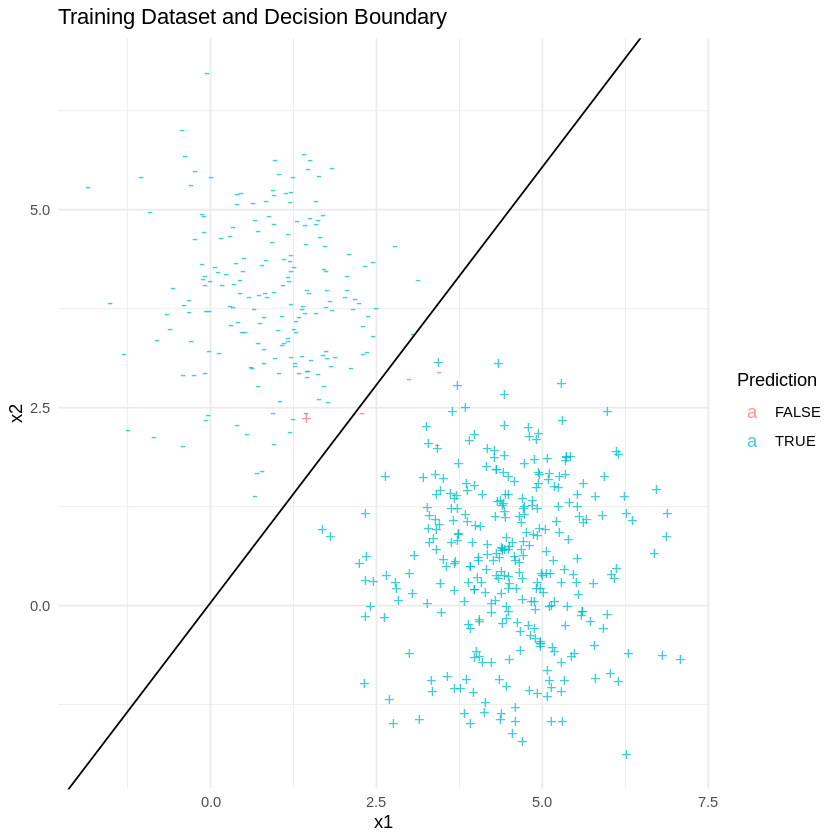

In [7]:
# visualize:
ggplot(data=train.data, 
       aes(x=x1, 
           y=x2, 
           label=ifelse(train.label!=c1, '+', '-'), 
           color=factor(predict(w,train.data,c0,c1)==train.label))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    geom_abline(intercept=-w[1]/w[3], slope=-w[2]/w[3]) +
    ggtitle('Training Dataset and Decision Boundary') +
    theme_minimal()

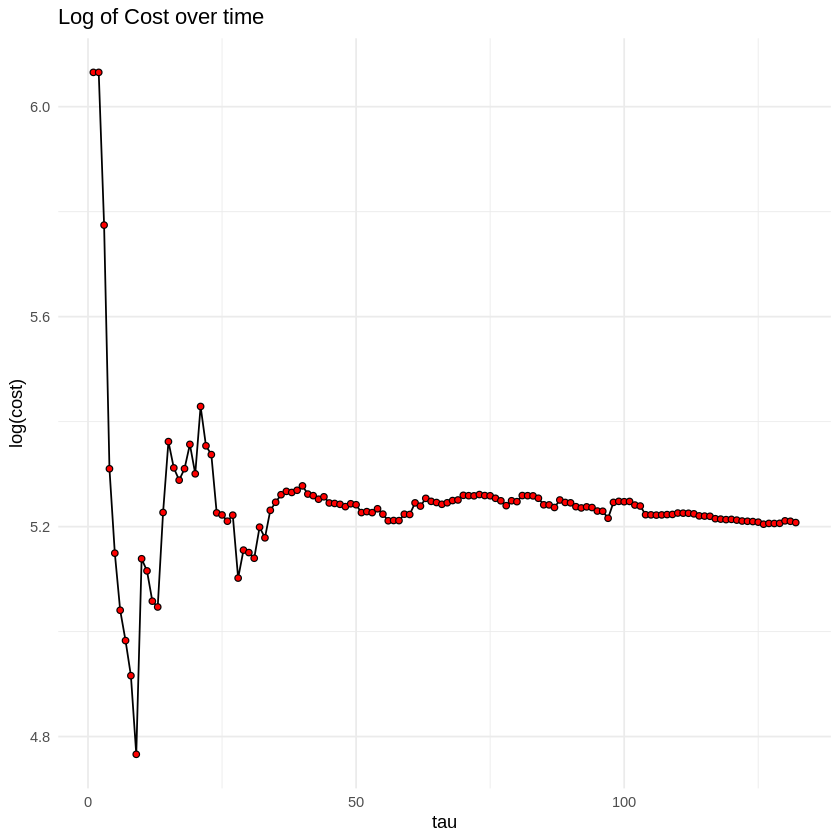

In [8]:
ggplot(data=costs, aes(x=tau, y=log(cost)), color=black) +
    geom_line() + 
    ggtitle('Log of Cost over time') + 
    geom_point(shape=21, fill='red')  +
    theme_minimal()

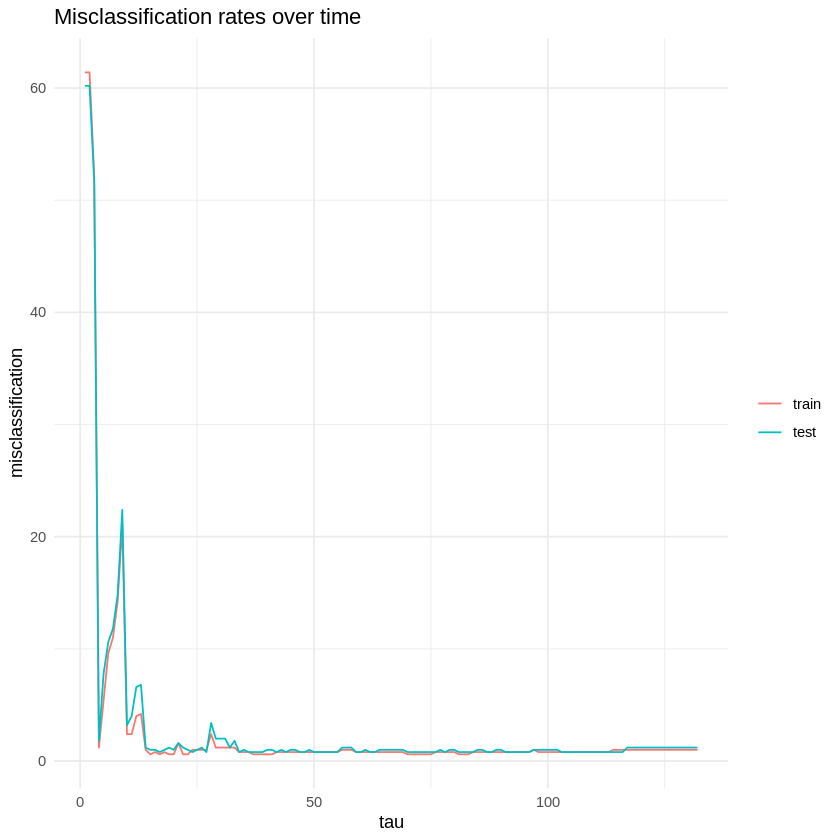

In [9]:
errors.m <- melt(errors, id='tau')
names(errors.m) <- c('tau', 'set', 'misclassification')

# plot missclassification error for train and test sets overtime
g <- ggplot(data = errors.m, aes(x = tau, y = misclassification, color = factor(set))) + 
    geom_line() +  
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Misclassification rates over time') + 
    theme_minimal()
print(g)

# Discussions:
1. How can we modify the cost function to prevent overfitting? Discuss the possibility of adding regularization term(s).
2. Discuss what will happen if the train sample size was very small.
3. Discuss what will happen if the classes were not linearly separable.
4. Discuss the benefit of having the probability of class membership (produced by the probabilistic models like logistic regresion) over only having the predicted class labels (similar to the output of perceptron, for example).
5. Modify your code and develop a batch gradient descent and compare it with SGD. Discuss your findings (e.g., convergence speed and chance of overfitting).